In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from pathlib import Path
from transformers import ViTForImageClassification

from datamodules import ImageDataModule
from models_vit_v2 import ImageClassificationNet

# Seed
pl.seed_everything(42)


class CONFIG:
    dataset = 'dog_cat'
    data_dir = str(Path.home() / f'Desktop/{dataset}')
    model_name = 'google/vit-base-patch16-224-in21k'
    checkpoint = None
    num_epochs = 4
    optimizer = 'AdamW'  # choices: RAdam
    lr = 5e-5
    num_class = 2
    num_worker = 0

Global seed set to 42


In [2]:
# Datamodule
dm = ImageDataModule(model_name=CONFIG.model_name, data_dir=CONFIG.data_dir, num_workers=CONFIG.num_worker)
train_ds, val_ds, test_ds = dm.setup()

Resolving data files:   0%|          | 0/25000 [00:00<?, ?it/s]

Using custom data configuration default-f820ea7ec07ebb6b
Found cached dataset imagefolder (C:/Users/Kevin/.cache/huggingface/datasets/imagefolder/default-f820ea7ec07ebb6b/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)
Loading cached split indices for dataset at C:/Users/Kevin/.cache/huggingface/datasets/imagefolder/default-f820ea7ec07ebb6b/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f\cache-d87df303e46fb703.arrow and C:/Users/Kevin/.cache/huggingface/datasets/imagefolder/default-f820ea7ec07ebb6b/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f\cache-fbb85d5624f086a4.arrow
Loading cached split indices for dataset at C:/Users/Kevin/.cache/huggingface/datasets/imagefolder/default-f820ea7ec07ebb6b/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f\cache-5a0f117cfc5ba029.arrow and C:/Users/Kevin/.cache/huggingface/datasets/imagefolder/default-f820ea7ec07ebb6b/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5a

In [3]:
train_ds.features['label'].names

['cat', 'dog']

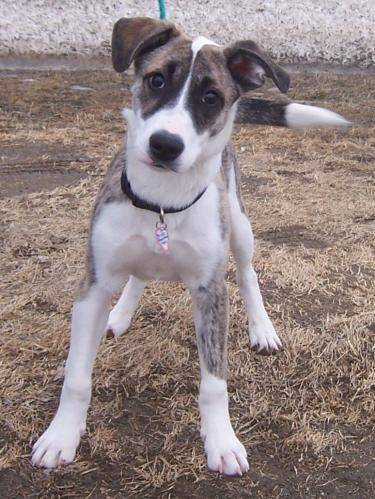

In [4]:
train_ds[5]['image']

In [38]:
id2label = {idx: label for idx, label in enumerate(train_ds.features['label'].names)}
label2id = {label: idx for idx, label in id2label.items()}
id2label

{0: 'cat', 1: 'dog'}

In [39]:
from transformers import ViTFeatureExtractor
from torchvision import transforms


model_checkpoint = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_checkpoint)
_train_transforms = transforms.Compose(
    [
        transforms.RandomResizedCrop(feature_extractor.size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
    ]
)

_val_transforms = transforms.Compose(
    [
        transforms.Resize(feature_extractor.size),
        transforms.CenterCrop(feature_extractor.size),
        transforms.ToTensor(),
        transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
    ]
)

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [40]:
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [41]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x374>,
 'label': 1,
 'pixel_values': tensor([[[-0.0431, -0.0510, -0.0510,  ...,  0.3804,  0.3647,  0.3804],
          [ 0.0039, -0.0118, -0.0275,  ...,  0.3647,  0.3647,  0.3647],
          [ 0.0275,  0.0118, -0.0118,  ...,  0.3569,  0.3490,  0.3490],
          ...,
          [ 0.2314,  0.2784,  0.3333,  ...,  0.5451,  0.5294,  0.5216],
          [ 0.2314,  0.2863,  0.3490,  ...,  0.5608,  0.5451,  0.5373],
          [ 0.3333,  0.3804,  0.4353,  ...,  0.5843,  0.5608,  0.5451]],
 
         [[-0.3647, -0.3725, -0.3490,  ..., -0.0275, -0.0431, -0.0275],
          [-0.3255, -0.3333, -0.3255,  ..., -0.0431, -0.0431, -0.0431],
          [-0.3020, -0.3098, -0.3020,  ..., -0.0510, -0.0588, -0.0588],
          ...,
          [-0.0431, -0.0196,  0.0353,  ...,  0.2549,  0.2392,  0.2314],
          [-0.0431,  0.0118,  0.0745,  ...,  0.2784,  0.2627,  0.2471],
          [ 0.0588,  0.1216,  0.1765,  ...,  0.2941,  0.2706,  0.2549]]

In [5]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import pytorch_lightning as pl
from transformers import ViTForImageClassification, AdamW


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


batch_size = 16
# num_workers = 24

train_dataloader = DataLoader(train_ds, shuffle=True, collate_fn=collate_fn, batch_size=batch_size)
val_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=batch_size)

In [10]:
next(iter(train_dataloader))['pixel_values']

tensor([[[[ 0.3020,  0.3176,  0.3412,  ...,  0.2314,  0.2314,  0.2235],
          [ 0.3020,  0.3176,  0.3412,  ...,  0.2157,  0.2235,  0.2235],
          [ 0.2941,  0.3176,  0.3412,  ...,  0.1922,  0.2000,  0.2235],
          ...,
          [ 0.3255,  0.3255,  0.3333,  ...,  0.5529,  0.5608,  0.5765],
          [ 0.3176,  0.3176,  0.3255,  ...,  0.5765,  0.5765,  0.5843],
          [ 0.3176,  0.3176,  0.3255,  ...,  0.5843,  0.5843,  0.5843]],

         [[ 0.2941,  0.3020,  0.3176,  ...,  0.2314,  0.2314,  0.2235],
          [ 0.2941,  0.3020,  0.3176,  ...,  0.2157,  0.2235,  0.2235],
          [ 0.2863,  0.2941,  0.3176,  ...,  0.1922,  0.2000,  0.2235],
          ...,
          [ 0.3333,  0.3333,  0.3412,  ...,  0.5608,  0.5686,  0.5843],
          [ 0.3255,  0.3255,  0.3333,  ...,  0.5843,  0.5843,  0.5922],
          [ 0.3255,  0.3255,  0.3333,  ...,  0.5922,  0.5922,  0.5922]],

         [[ 0.1294,  0.1451,  0.1686,  ...,  0.2157,  0.2157,  0.2078],
          [ 0.1294,  0.1451,  

In [43]:
class ViTLightningModule(pl.LightningModule):
    def __init__(self, model_name, id_label, label_id):
        super(ViTLightningModule, self).__init__()
        self.model_name = model_name
        self.id_label = id_label
        self.label_id = label_id
        self.num_labels = len(label2id)
        self.vit = ViTForImageClassification.from_pretrained(self.model_name, num_labels=self.num_labels,
                                                             id2label=self.id_label, label2id=self.label_id)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits
        
    def common_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        logits = self(pixel_values)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/pixel_values.shape[0]

        return loss, accuracy
      
    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        return loss

    def configure_optimizers(self):
        # We could make the optimizer more fancy by adding a scheduler and specifying which parameters do
        # not require weight_decay but just using AdamW out-of-the-box works fine
        return AdamW(self.parameters(), lr=5e-5)

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

    def test_dataloader(self):
        return test_dataloader

In [44]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping


early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    strict=False,
    verbose=False,
    mode='min'
)

model = ViTLightningModule(model_checkpoint, id2label, label2id)
trainer = Trainer(gpus=1, callbacks=[EarlyStopping(monitor='validation_loss')])
trainer.fit(model)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\Kevin\miniconda3\envs\nlp\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [46]:
trainer.validate()

C:\Users\Kevin\miniconda3\envs\nlp\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:134: UserWarning: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at C:\Users\Kevin\PycharmProjects\data_toolkit\computer_vision\vit_transformers\lightning_logs\version_1\checkpoints\epoch=4-step=6250.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at C:\Users\Kevin\PycharmProjects\data_toolkit\computer_vision\vit_transformers\lightning_logs\version_1\checkpoints\epoch=4-step=6250.ckpt
C:\Users\Kevin\miniconda3\envs\nlp\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader

Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   validation_accuracy      0.9932000041007996
     validation_loss       0.022099226713180542
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'validation_loss': 0.022099226713180542,
  'validation_accuracy': 0.9932000041007996}]

In [48]:
torch.save(model.state_dict(), 'model/vit_finetune.pt')